In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape

M, D, C = X_train.shape[0], X_train.shape[1], y_train.max() + 1
# M, D, C

X_train, X_val, X_test = l.prepro(X_train, X_val, X_test)
# X_train.shape, X_val.shape, X_test.shape
# if net_type == 'cnn':
img_shape = (1, 28, 28)

X_train = X_train.reshape(-1, *img_shape)
X_val = X_val.reshape(-1, *img_shape)
X_test = X_test.reshape(-1, *img_shape)
X_train.shape, X_val.shape, X_test.shape

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


((55000, 1, 28, 28), (5000, 1, 28, 28), (10000, 1, 28, 28))

In [5]:
# Model
import impl.layer as l

class CNN:

    def __init__(self, D, C, H, L, p_dropout):
        self.p_dropout = p_dropout
        self.mode = 'classification'
        self.L = L # number of layers or depth
        self.p_dropout = p_dropout
        self.losses = {'train':[]}
        
        # Model parameters: weights and biases
        # Input layer of Conv
        self.model = []
        self.model.append(dict(
            W1=np.random.randn(H, 1, 3, 3) / np.sqrt(H / 2.),
            b1=np.zeros((H, 1)),
            W1_res=np.random.randn(H, 1, 3, 3) / np.sqrt(H / 2.),
            b1_res=np.zeros((H, 1))
        ))
        
        # Hidden layers of Conv-bn-relu-dropout
        m = []
        self.bn_caches = []
        for _ in range(self.L):
            m.append(dict(
                    W2=np.random.randn(H, H, 3, 3) / np.sqrt(H / 2.),
                    b2=np.zeros((H, 1)),
                    W2_res=np.random.randn(H, H, 3, 3) / np.sqrt(H / 2.),
                    b2_res=np.zeros((H, 1))
            ))
        self.model.append(m) # self.model[0][]
        
        # Output layer of FC to output
        self.model.append(dict(
            W3=np.random.randn(H*D, C) / np.sqrt(H*D / 2.),
            b3=np.zeros((1, C))
        ))

    def selu_forward(self, X):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        out = scale * np.where(X>=0.0, X, alpha * (np.exp(X)-1))
        cache = X
        return out, cache

    def selu_backward(self, dout, cache):
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        X = cache
        dX_pos = dout.copy()
        dX_pos[X<0] = 0
        dX_neg = dout.copy()
        dX_neg[X>0] = 0
        dX = scale * np.where(X>=0.0, dX_pos, dX_neg * alpha * np.exp(X))
        return dX

    def alpha_dropout_fwd(self, h, q):
        '''h is activation, q is keep probability: q=1-p, p=p_dropout, and q=keep_prob'''
        alpha = 1.6732632423543772848170429916717
        scale = 1.0507009873554804934193349852946
        alpha_p = -scale * alpha
        mask = np.random.binomial(1, q, size=h.shape)
        dropped = mask * h + (1 - mask) * alpha_p
        a = 1. / np.sqrt(q + alpha_p ** 2 * q  * (1 - q))
        b = -a * (1 - q) * alpha_p
        out = a * dropped + b
        cache = (a, mask)
        return out, cache

    def alpha_dropout_bwd(self, dout, cache):
        a, mask = cache
        d_dropped = dout * a
        dh = d_dropped * mask
        return dh

    def forward(self, X, train):

        # 1st layer: Input to Conv
        h1_res, conv1_res_cache = l.conv_forward(X=X, W=self.model[0]['W1_res'], b=self.model[0]['b1_res']) 
        h1, conv1_cache = l.conv_forward(X=X, W=self.model[0]['W1'], b=self.model[0]['b1']) 
        #         h2, nl1_cache = l.relu_forward(h1)
        h2, nl1_cache = self.selu_forward(h1)
        if train: 
            do1_cache = None
            #         if train: h2, do1_cache = self.dropout_selu_forward(X=h2, p_dropout=self.p_dropout)
            h2, do1_cache = self.alpha_dropout_fwd(h=h2, q=self.p_dropout)
            # x = x + f(x)
            h1_res += h2
            h1_cache = (conv1_res_cache, conv1_cache, nl1_cache, do1_cache)
        else: 
            # x = x + f(x)
            h1_res += h2
            h1_cache = (conv1_res_cache, conv1_cache, nl1_cache)

        ###########################################################################################
        # midst layer: Convnet 1
        h2_cache = []
        for layer in range(self.L):
            if not layer == 0: h2 = h2.reshape(nl1_cache.shape)

            h2_res, conv2_res_cache = l.conv_forward(X=h2, W=self.model[1][layer]['W2_res'], 
                                                     b=self.model[1][layer]['b2_res'])
            h2_res = h2_res.reshape([nl1_cache.shape[0], -1])

            h2, conv2_cache = l.conv_forward(X=h2, W=self.model[1][layer]['W2'], b=self.model[1][layer]['b2'])
            h2 = h2.reshape([nl1_cache.shape[0], -1])
            
            #             h2, nl2_cache = l.relu_forward(h2)
            h2, nl2_cache = self.selu_forward(X=h2)
            if train: 
                do2_cache = None # ERROR: referenced before assigned!
                #             if train: h2, do2_cache = l.dropout_forward(X=h2, p_dropout=self.p_dropout)
                #             if train: h2, do2_cache = self.dropout_selu_forward(X=h2, p_dropout=self.p_dropout)
                h2, do2_cache = self.alpha_dropout_fwd(h=h2, q=self.p_dropout)
                h2_res += h2    
                cache = (conv2_res_cache, conv2_cache, nl2_cache, do2_cache)
            else:
                h2_res += h2    
                cache = (conv2_res_cache, conv2_cache, nl2_cache)

            h2_cache.append(cache)
        ############################################################################################
            
        # last layer : FC to Output
        h3, h3_cache = l.fc_forward(X=h2, W=self.model[2]['W3'], b=self.model[2]['b3'])

        cache = (h1_cache, h2_cache, h3_cache)
        return h3, cache

    def cross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        prob = l.softmax(y_pred)
        log_like = -np.log(prob[range(m), y_train])
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_pred, y_train):
        m = y_pred.shape[0]

        grad_y = l.softmax(y_pred)
        grad_y[range(m), y_train] -= 1.0
        grad_y /= m

        return grad_y

    def loss_function(self, y, y_train):
        loss = self.cross_entropy(y, y_train) #/ y_train.shape[0] # (t, n)=txn, t: minibatch_size/ num_samples
        dy = self.dcross_entropy(y, y_train) #/ y_train.shape[0]
        return loss, dy
    
    def backward(self, dy, cache, train):
        h1_cache, h2_cache, h3_cache = cache
        if train: conv1_res_cache, conv1_cache, nl1_cache, do1_cache = h1_cache
        else: conv1_res_cache, conv1_cache, nl1_cache = h1_cache

        # last layer
        dh2, dw3, db3 = l.fc_backward(dout=dy, cache=h3_cache)
        
        # midst layer 2
        g = []
        for layer in reversed(range(self.L)):
            
            conv2_res_cache, conv2_cache, nl2_cache, do2_cache = h2_cache[layer]
            dh2_res = dh2.reshape(nl1_cache.shape)
            dh2_res, dw2_res, db2_res = l.conv_backward(dout=dh2_res, cache=conv2_res_cache)
            
            if train:
                #             dh2 = l.dropout_backward(dout=dh2, cache=do2_cache)
                #             dh2 = self.dropout_selu_backward(dout=dh2, cache=do2_cache)
                dh2 = self.alpha_dropout_bwd(dout=dh2, cache=do2_cache)
                
            #             dh2 = l.relu_backward(dout=dh2, cache=nl2_cache)
            dh2 = self.selu_backward(dout=dh2, cache=nl2_cache)
            dh2 = dh2.reshape(nl1_cache.shape)
            dh2, dw2, db2 = l.conv_backward(dout=dh2, cache=conv2_cache)
            dh2 += dh2_res
            if not layer==0: dh2 = dh2.reshape([nl1_cache.shape[0], -1])
            g.append(dict(
                    W2=dw2,
                    b2=db2,
                    W2_res=dw2_res,
                    b2_res=db2_res
                    ))
            
        # 1st layer
        #         conv1_res_cache, conv1_cache, nl1_cache, do1_cache = h1_cache
        dX_res, dw1_res, db1_res = l.conv_backward(dout=dh2, cache=conv1_res_cache)
        #         dh2 = self.dropout_selu_backward(dout=dh2, cache=do1_cache)
        if train: dh2 = self.alpha_dropout_bwd(dout=dh2, cache=do1_cache)
        #         dh1 = l.relu_backward(dout=dh2, cache=nl1_cache)
        dh1 = self.selu_backward(dout=dh2, cache=nl1_cache)
        dX, dw1, db1 = l.conv_backward(dout=dh1, cache=conv1_cache)
        dX += dX_res

        # grad for GD
        grad = []
        
        # Input layer to conv layer
        grad.append(dict(
            W1=dw1, 
            b1=db1,
            W1_res=dw1_res, 
            b1_res=db1_res
        ))
        
        # Hidden layers of conv-bn-nl/relu-dropout/do
        grad.append(g)
        
        # Output later to FC layer
        grad.append(dict(
            W3=dw3, 
            b3=db3
        ))
        
        return dX, grad
    
    def test(self, X):
        y_logit, cache = self.forward(X, train=False)
        y_prob = l.softmax(y_logit)
        if self.mode == 'classification':
            return np.argmax(y_prob, axis=1)
        else: # self.mode == 'regression'
            return np.round(y_logit)

In [6]:
# SGD
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam(nn, X_train, y_train, val_set, alpha, mb_size, n_iter, print_after):
    if val_set:
        X_val, y_val = val_set
        
    M, R = [], []
    M.append({key: np.zeros_like(val) for key, val in nn.model[0].items()})
    R.append({key: np.zeros_like(val) for key, val in nn.model[0].items()})
    
    M_, R_ = [], []
    for layer in range(nn.L):
        M_.append({key: np.zeros_like(val) for key, val in nn.model[1][layer].items()})
        R_.append({key: np.zeros_like(val) for key, val in nn.model[1][layer].items()})
    M.append(M_)
    R.append(R_)

    M.append({key: np.zeros_like(val) for key, val in nn.model[2].items()})
    R.append({key: np.zeros_like(val) for key, val in nn.model[2].items()})
    
    beta1 = .99
    beta2 = .999
    #     import impl.constant as c, c.eps
    eps = 1e-8 # constant

    # Epochs
    for iter in range(1, n_iter + 1):
        
        # Minibatches
        #         """
        #         Single training step over minibatch: forward, loss, backprop
        #         """
        # Shuffle for each epochs/ stochasticity/ randomly choosing
        minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=True)
        for _ in range(10):
            idx = np.random.randint(0, len(minibatches))
            #         for idx in range(len(minibatches)):
            X_mini, y_mini = minibatches[idx]
            y, cache = nn.forward(X_mini, train=True)
            loss, dy = nn.loss_function(y, y_mini)
            dX, grad = nn.backward(dy, cache, train=True)
            nn.losses['train'].append(loss)

            for key in grad[0]:
                M[0][key] = l.exp_running_avg(M[0][key], grad[0][key], beta1)
                R[0][key] = l.exp_running_avg(R[0][key], grad[0][key]**2, beta2)

                m_k_hat = M[0][key] / (1. - (beta1**(iter)))
                r_k_hat = R[0][key] / (1. - (beta2**(iter)))

                nn.model[0][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            for layer in range(nn.L):
                for key in grad[1][layer]:
                    M[1][layer][key] = l.exp_running_avg(M[1][layer][key], grad[1][layer][key], beta1)
                    R[1][layer][key] = l.exp_running_avg(R[1][layer][key], grad[1][layer][key]**2, beta2)

                    m_k_hat = M[1][layer][key] / (1. - (beta1**(iter)))
                    r_k_hat = R[1][layer][key] / (1. - (beta2**(iter)))

                    nn.model[1][layer][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

            for key in grad[2]:
                M[2][key] = l.exp_running_avg(M[2][key], grad[2][key], beta1)
                R[2][key] = l.exp_running_avg(R[2][key], grad[2][key]**2, beta2)

                m_k_hat = M[2][key] / (1. - (beta1**(iter)))
                r_k_hat = R[2][key] / (1. - (beta2**(iter)))

                nn.model[2][key] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + eps)

        # Epochs
        if iter % print_after == 0:
            if val_set:
                val_acc = l.accuracy(y_val, nn.test(X_val))
                print('Iter-{} training loss: {:.4f} validation accuracy: {:4f}'.format(iter, loss, val_acc))
                
    return nn

In [4]:
# Hyper-parameters
n_iter = 100 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 64 # width, timestep for sequential data or minibatch size
num_layers = 2 # depth 
print_after = n_iter//10 # print loss for train, valid, and test
num_hidden_units = 8
p_dropout = 0.95 #  keep_prob = 1.0 - p_dropout, q = 1-p, q=0.95, o=0.05

# build the model/NN and learn it: running session.
net = CNN(C=C, D=D, H=num_hidden_units, p_dropout=p_dropout, L=num_layers)

net = adam(nn=net, X_train=X_train, y_train=y_train, val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

y_pred = net.test(X_test)
accs = np.mean(y_pred == y_test)
print('Test Mean accuracy: {:.4f}, std: {:.4f}'.format(accs.mean(), accs.std()))

Iter-10 training loss: 5.1880 validation accuracy: 0.850200
Iter-20 training loss: 1.7259 validation accuracy: 0.900600
Iter-30 training loss: 5.7726 validation accuracy: 0.908400
Iter-40 training loss: 4.9907 validation accuracy: 0.902600
Iter-50 training loss: 3.0941 validation accuracy: 0.926200
Iter-60 training loss: 2.0855 validation accuracy: 0.929600
Iter-70 training loss: 3.2685 validation accuracy: 0.924600
Iter-80 training loss: 3.3855 validation accuracy: 0.929000
Iter-90 training loss: 3.2735 validation accuracy: 0.929200
Iter-100 training loss: 2.7068 validation accuracy: 0.936800
Test Mean accuracy: 0.9292, std: 0.0000


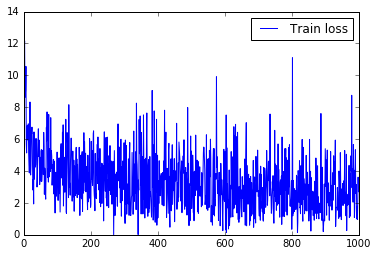

In [7]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.legend()
plt.show()